# Load and preprocess DVS input for SNN

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from snntoolbox.config import settings as s

In [7]:
def remove_outliers(timestamps, xaddr, yaddr, pol, x_max=240, y_max=180):
    len_orig = len(timestamps)
    xaddr_valid = np.where(np.array(xaddr) < x_max)
    yaddr_valid = np.where(np.array(yaddr) < y_max)
    xy_valid = np.intersect1d(xaddr_valid[0], yaddr_valid[0], True)
    xaddr = np.array(xaddr)[xy_valid]
    yaddr = np.array(yaddr)[xy_valid]
    timestamps = np.array(timestamps)[xy_valid]
    pol = np.array(pol)[xy_valid]
    num_outliers = len_orig - len(timestamps)
    if num_outliers:
        print("Removed {} outliers.".format(num_outliers))
    return timestamps, xaddr, yaddr, pol


def load_dvs_input(path, label_dict, xyrange=None):

    from snntoolbox.io_utils.AedatTools import ImportAedat
        
    timestamps_all = []
    xaddr_all = []
    yaddr_all = []
    pol_all = []
    labels = []
    
    sample_filenames = sorted(os.listdir(path))
    for filename in sample_filenames[7:8]:
        # Determine class label
        label = None
        for class_idx, class_label in zip(label_dict.keys(), label_dict.values()):
            if class_label in filename:
                label = class_idx
        if label is None:
            print("Could not identify class label of data sample! Aborting.")
            break
        
        # Load aedat file
        datafile = os.path.join(path, filename)
        print("Loading {}".format(datafile))
        events = ImportAedat.import_aedat({'filePathAndName': datafile})['data']['polarity']
        timestamps = events['timeStamp']
        xaddr = events['x']
        yaddr = events['y']
        pol = events['polarity']

        # Remove events with addresses outside valid range
        if xyrange:
            timestamps, xaddr, yaddr, pol = remove_outliers(
                timestamps, xaddr, yaddr, pol, xyrange[0], xyrange[1])
        
        # Append sample
        timestamps_all.append(timestamps)
        xaddr_all.append(xaddr)
        yaddr_all.append(yaddr)
        pol_all.append(pol)
        labels.append(label)
    
    return np.array(timestamps_all), np.array(xaddr_all), np.array(yaddr_all), \
        np.array(pol_all), np.array(labels)

## Load DVS sequences

In [8]:
path = '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_all/paper'
label_dict = {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}
timestamps_all, xaddr_all, yaddr_all, pol_all, labels = load_dvs_input(path, label_dict, (240, 180))

Loading /home/rbodo/.snntoolbox/Datasets/roshambo/DVS_all/paper/paper_enea_back.aedat


Removed 0 outliers.


## Plot an "event-frame" consisting of 1000 events

(0, 200.0)

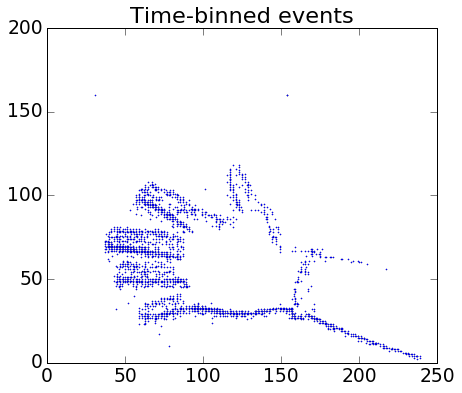

In [9]:
sample_idx = 0
frame_idx = 1
width = 2000
plt.scatter(xaddr_all[sample_idx][frame_idx*width:(frame_idx+1)*width], yaddr_all[sample_idx][frame_idx*width:(frame_idx+1)*width], s=2, linewidths=0.1)
plt.title('Time-binned events')
plt.xlim(0, None)
plt.ylim(0, None)

## Plot accumulation of all events

(0, 160.0)

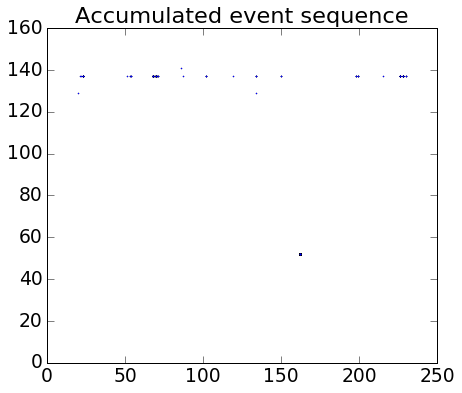

In [6]:
plt.scatter(xaddr_all[0], yaddr_all[0], s=2, linewidths=0.1)
plt.title('Accumulated event sequence')
plt.xlim(0, None)
plt.ylim(0, None)

## Plot timestamps of event sequence

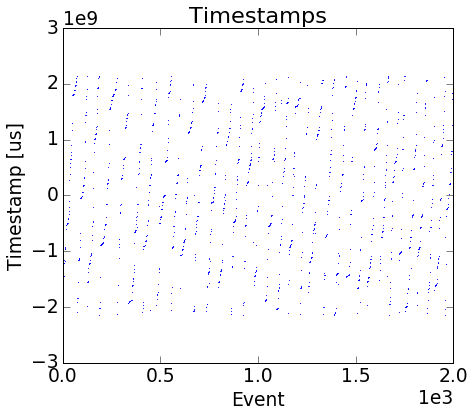

In [7]:
plt.plot(timestamps_all[0][2000:4000], '.', markersize=1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.title('Timestamps')
plt.xlabel('Event')
plt.ylabel('Timestamp [us]')

## Compare different sub-sampling techniques

In [141]:
from PIL import Image

x_test_sub1 = []
x_test_full = []  # Not downsampled
snapshot_durations = []
# Loop over all samples
for x_list, y_list, ts_list in zip(xaddr_all, yaddr_all, timestamps_all):
    # Snapshot with at most one event per pixel
    inp_shallow = np.zeros((180, 240))
    # List of snapshots
    inp_t = []
    inp_t_full = []  # not downsampled
    # List of latest timestamps per snapshot
    inp_ts = []
    # Loop over all events of sample
    for e_x, e_y, e_ts in zip(x_list, y_list, ts_list):
        if inp_shallow[e_y, e_x] == 0:
            inp_shallow[e_y, e_x] += 1
        else:
            # Downsample snapshot and add it to the others
            inp_downsampled = np.array(Image.fromarray(inp_shallow).resize((64, 64)), ndmin=3)
            inp_t.append(inp_downsampled)
            inp_t_full.append(inp_shallow)
            inp_ts.append(e_ts)
            # Start new snapshot
            inp_shallow = np.zeros((180, 240))
    x_test_sub1.append(np.array(inp_t, 'float32'))
    x_test_full.append(np.array(inp_t_full, 'float32'))
    snapshot_durations.append(np.diff(inp_ts))

In [142]:
from skimage.measure import block_reduce
x_test_sub2 = []
x_test_sub3 = []
for sample in x_test_full:
    x_test_sub2.append(np.pad(block_reduce(sample, (1, 3, 4), np.max), ((0, 0), (2, 2), (2, 2)), 'constant', constant_values=0))
    x_test_sub3.append(np.pad(block_reduce(sample, (1, 3, 4), np.sum), ((0, 0), (2, 2), (2, 2)), 'constant', constant_values=0))

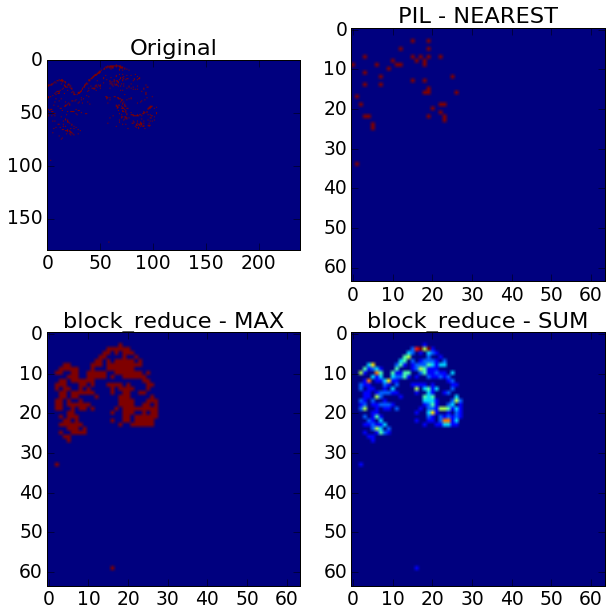

In [146]:
sample_idx = 0
snapshot_idx = 5000

f, ax = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
ax[0, 0].imshow(np.squeeze(x_test_full[sample_idx][snapshot_idx]))
ax[0, 1].imshow(np.squeeze(x_test_sub1[sample_idx][snapshot_idx]))
ax[1, 0].imshow(np.squeeze(x_test_sub2[sample_idx][snapshot_idx]))
ax[1, 1].imshow(np.squeeze(x_test_sub3[sample_idx][snapshot_idx]))
ax[0, 0].set_title("Original")
ax[0, 1].set_title("PIL - NEAREST")
ax[1, 0].set_title("block_reduce - MAX")
ax[1, 1].set_title("block_reduce - SUM")